In [2]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/helpers"))

In [3]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [4]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.9
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 5400
Test set size: 600


In [204]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = i #train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]

In [205]:
dim1_data = t_x_data
dim2_data = t_y_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()

In [206]:
from data_preparation import sliding_window_delta

training_data = np.array(dim1_data_scaled.reshape(-1,1))
print(training_data)
print(training_data.shape)
training_data = np.append(training_data, dim2_data_scaled.reshape(-1,1),axis=1)
print(training_data)
print(training_data.shape)

seq_length = 10
x, y = sliding_window_delta(training_data, seq_length)

train_val_ratio = 0.5
train_size = int(len(y) * train_val_ratio)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

valX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
valY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("valX:",valX.shape)
print("dataY:",dataY.shape)
print("trainY:",trainY.shape)
print("valY:",valY.shape)

# plt.plot(trainX[:,0,0])
# plt.plot(trainX[:,0,1])

[[-1.37088955]
 [-1.36970395]
 [-1.3675547 ]
 ...
 [-1.37270585]
 [-1.38132449]
 [-1.37052975]]
(5400, 1)
[[-1.37088955 -1.73173009]
 [-1.36970395 -1.73108859]
 [-1.3675547  -1.73044709]
 ...
 [-1.37270585  1.73044709]
 [-1.38132449  1.73108859]
 [-1.37052975  1.73173009]]
(5400, 2)
dataX: torch.Size([5390, 10, 2])
trainX: torch.Size([2695, 10, 2])
valX: torch.Size([2695, 10, 2])
dataY: torch.Size([5390, 2])
trainY: torch.Size([2695, 2])
valY: torch.Size([2695, 2])


In [207]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_dim, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [209]:
torch.manual_seed(0)

num_epochs = 301
learning_rate = 0.01

input_size = 2
output_size = 2
hidden_size = 30
num_layers = 1

lstm = LSTM(input_size, output_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

print(lstm(trainX).size())
print(trainY.size())

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX).reshape(-1,output_size)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([2695, 2])
torch.Size([2695, 2])
Epoch: 0, loss: 0.00690
Epoch: 50, loss: 0.00390
Epoch: 100, loss: 0.00386
Epoch: 150, loss: 0.00359
Epoch: 200, loss: 0.00597
Epoch: 250, loss: 0.00264
Epoch: 300, loss: 0.00247


In [210]:
print(output_size)
print(lstm(trainX).shape)
print(outputs.size())
print(trainY.size())

2
torch.Size([2695, 2])
torch.Size([2695, 2])
torch.Size([2695, 2])


In [211]:
def appender(input_seq,new_val):
    """
    Append value to input sequence (treat as arrays)
    """
    import numpy as np

    input_seq = np.delete(input_seq,0,axis=0)
    updated_input_seq = np.append(input_seq,new_val).reshape(-1,2) # hacky, remove this 2
    return updated_input_seq
my_arr = np.array([[0,1],[2,3],[4,5],[6,7]])
print(my_arr,"shape:",my_arr.shape)
my_new_arr = appender(my_arr,[8,9])
print(my_new_arr,"shape:",my_new_arr.shape)

[[0 1]
 [2 3]
 [4 5]
 [6 7]] shape: (4, 2)
[[2 3]
 [4 5]
 [6 7]
 [8 9]] shape: (4, 2)


In [212]:
def get_predictions_out_to_horizon(model,horizon,input_seq,future_val):
    """
    Predict values out to a horizon
    """
    import numpy as np
    import torch
    from torch.autograd import Variable 

    cumulative_predictions = np.empty(0)
    cumulative_predictions = np.append(cumulative_predictions,future_val)
#     print("Future val:",future_val,'shape:',future_val.shape)
#     print("Input seq:",input_seq,'shape:',input_seq.shape)
    for i in range(horizon-1):
        updated_input_seq = appender(input_seq,future_val)
        updated_input_seq = updated_input_seq[np.newaxis,...]
        updated_input_seq = Variable(torch.tensor(updated_input_seq))
        next_prediction = model(updated_input_seq)

        # Update states
        input_seq = updated_input_seq
        future_val = next_prediction.data.numpy()+updated_input_seq[0][-1].data.numpy()
        cumulative_predictions = np.append(cumulative_predictions,future_val)
    return cumulative_predictions.reshape(-1,2)

# prediction_start_index = 160 #int(len(dataY)*train_test_ratio) + 10 #160
# horizon = 40
# lstm.eval()
# input_seq = dataX[prediction_start_index]
# future_val = lstm(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.numpy()

# print(lstm(dataX[[prediction_start_index]]),'shape:',lstm(dataX[[prediction_start_index]]).shape)
# print(lstm(dataX[[prediction_start_index]]).data.numpy(),'shape:',lstm(dataX[[prediction_start_index]]).data.numpy().shape)

# tmp_prev_data = dataX[prediction_start_index][-1].data.reshape(1,-1)
# print("Data from tm1",tmp_prev_data,"shape:",tmp_prev_data.shape)
# future_val = lstm(dataX[[prediction_start_index]]).data.numpy()[0][0] + tmp_prev_data

# print(future_val,'shape:',future_val.shape)

# predictions = get_predictions_out_to_horizon(lstm,horizon,input_seq,future_val)
# print(predictions,"shape:",predictions.shape)
# dim1_predictions_rescaled = predictions[:,0]*dim1_data.std()+dim1_data.mean()
# dim2_predictions_rescaled = predictions[:,1]*dim2_data.std()+dim2_data.mean()
# plt.plot(dim1_predictions_rescaled)
# plt.plot(dim2_predictions_rescaled)

# tmpy = dataX.data.numpy()[:,-1,1]
# print(tmpy,"shape:",tmpy.shape)
# # plt.plot(tmpy)
# tmpy = dataY.data.numpy()[:,1]
# print(tmpy,"shape:",tmpy.shape)

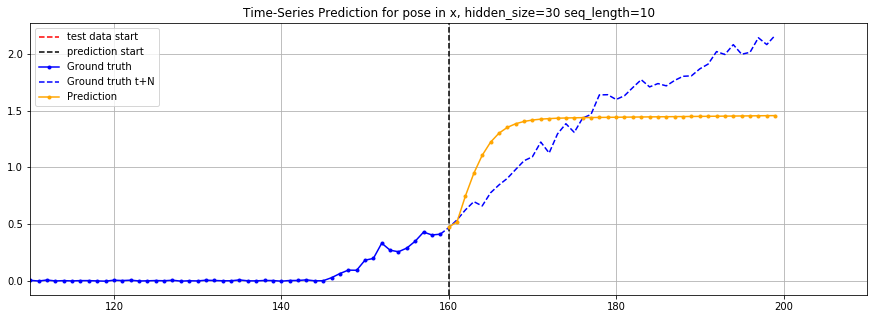

In [213]:
# from prediction import appender, get_predictions_out_to_horizon
prediction_start_index = 160 #int(len(dataY)*train_test_ratio) + 10 #160
horizon = 40
lstm.eval()
input_seq = dataX[prediction_start_index]
future_val = lstm(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.reshape(1,-1)
predictions = get_predictions_out_to_horizon(lstm,horizon,input_seq,future_val)

# Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
gt_x_vals_rescaled = (dataX.data.numpy()[:,-1,0]+dataY.data.numpy()[:,0])*dim1_data.std()+dim1_data.mean()

dim1_predictions_rescaled = predictions[:,0]*dim1_data.std()+dim1_data.mean()
dim2_predictions_rescaled = predictions[:,1]*dim2_data.std()+dim2_data.mean()

x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
view_size = horizon+10
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(gt_x_vals_rescaled[:prediction_start_index],'b.-',label="Ground truth")
plt.plot(x_axis_ticks_tm1,gt_x_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon],'b--',label="Ground truth t+N")
plt.plot(x_axis_ticks_horizon,dim1_predictions_rescaled,'.-',color="orange",label="Prediction")

title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

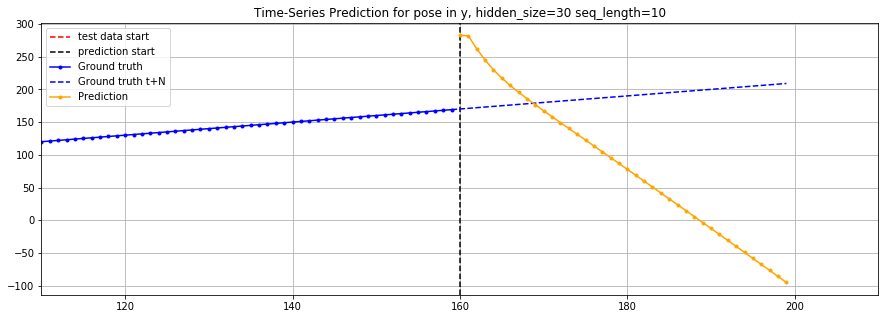

In [214]:
gt_y_vals_rescaled = (dataX.data.numpy()[:,-1,1]+dataY.data.numpy()[:,1])*dim2_data.std()+dim2_data.mean()

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
view_size = horizon+10
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(gt_y_vals_rescaled[:prediction_start_index],'b.-',label="Ground truth")
plt.plot(x_axis_ticks_tm1,gt_y_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon],'b--',label="Ground truth t+N")
plt.plot(x_axis_ticks_horizon,dim2_predictions_rescaled,'.-',color="orange",label="Prediction")

title_string = 'Time-Series Prediction for pose in y, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [13]:
import datetime
from time import strftime
print(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

from metrics import get_error_metrics

save_plots = True
prediction_start_index = 140 #int(len(dataY)*train_test_ratio) - 50
horizon = 40 -1 # -1 because we do first step outside the loop
num_frames_to_render = 50
all_short_rmse = []
all_med_rmse = []
all_long_rmse = []

experiment_dir = '/workspace/data/pose-prediction-odometry/'+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
if save_plots:
#     os.mkdir(experiment_dir)
    for frame in range(prediction_start_index,prediction_start_index+num_frames_to_render):
        prediction_start_index = frame
        lstm.eval()
        input_seq = dataX[prediction_start_index]
        future_val = lstm(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.numpy()
        predictions = get_predictions_out_to_horizon(lstm,horizon,input_seq,future_val)

        # Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
        data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
        gt_vals_rescaled = (dataX.data.numpy()[:,-1]+dataY.data.numpy())*dim1_data.std()+dim1_data.mean()

        # Error metrics
        gt_predictions = gt_vals_rescaled[prediction_start_index:prediction_start_index+horizon,0]
        model_predictions = data_predict_rescaled
        short_rmse, med_rmse, long_rmse = get_error_metrics(gt_predictions,model_predictions)
        all_short_rmse.append(short_rmse)
        all_med_rmse.append(med_rmse)
        all_long_rmse.append(long_rmse)
        
        x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
        x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

        fig = plt.figure(figsize=(15,5))
        plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
        plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
        view_size = horizon+10
        x_centre = prediction_start_index #len(dataY)*train_test_ratio
        plt.xlim(x_centre-view_size,x_centre+view_size)
        plt.plot(gt_vals_rescaled[:prediction_start_index,0],'b.-',label="Ground truth")
        plt.plot(x_axis_ticks_tm1,gt_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon,0],'b--',label="Ground truth t+N")
        plt.plot(x_axis_ticks_horizon,data_predict_rescaled,'.-',color="orange",label="Prediction")

        title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
                     +' seq_length='+str(seq_length)
        plt.title(title_string)
        plt.grid()
        plt.legend()
#         plt.savefig("%s%s%i%s%i%s" % (experiment_dir,'/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
#                 bbox_inches='tight')
        plt.close(fig)
print("Mean short RMSE:",np.array(all_short_rmse).mean())
print("Mean med RMSE:",np.array(all_med_rmse).mean())
print("Mean long RMSE:",np.array(all_long_rmse).mean())


09-06-2020-13-40-04
Mean short RMSE: 0.12775371273166877
Mean med RMSE: 0.51327513330551
Mean long RMSE: 1.0445225839456647
